In [1]:
import xarray as xr
import numpy as np
import holoviews as hv
from pathlib import Path
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
# %matplotlib widget
import panel as pn
from holoviews import opts
import dask.array as da
from dask.distributed import Client, LocalCluster
import param
from holoviews import streams
from scipy.ndimage import label, find_objects
# Get working directory
import sys, os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import marineHeatWaves as mhw

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import dask.array as da
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
dataset_path = '..\..\output\Garda_heatwaves_dataset.nc'

ds_heatwaves = xr.open_dataset(dataset_path)# chunks='auto'
# Create a mask for the lake area
mask = ~np.isnan(ds_heatwaves['intensity'].max(dim='time'))

ds_heatwaves 

<xarray.Dataset>
Dimensions:                       (time: 1500, lat: 52, lon: 43)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01 ... 2022-1...
  * lat                           (lat) float64 45.45 45.45 ... 45.86 45.87
  * lon                           (lon) float64 10.51 10.52 ... 10.85 10.86
Data variables: (12/24)
    lswt                          (time, lat, lon) float32 ...
    clim                          (time, lat, lon) float64 ...
    thresh                        (time, lat, lon) float64 ...
    intensity                     (time, lat, lon) float64 nan nan ... nan nan
    category                      (time, lat, lon) float64 ...
    extrathresh                   (time, lat, lon) float64 ...
    ...                            ...
    displacement_module           (time) float64 ...
    cell_total_hws_days           (lat, lon) float64 ...
    cell_mean_intensity           (lat, lon) float64 ...
    cell_max_intensity            (lat, lon) float64 ...
    cell_cumulative_intensity     (lat, lon) float64 ...
    season                        (time) object ...

In [4]:
# Extract relevant data variables
intensity = ds_heatwaves['intensity'].values
hws_area_percentage = ds_heatwaves['hws_area_percentage'].values
time = ds_heatwaves['time'].values


# Identify individual heatwave events based on gaps in the time series
time_gaps = np.diff(time) > np.timedelta64(1, 'D')
event_indices = np.where(time_gaps)[0] + 1

# Split data into individual events
events = np.split(intensity, event_indices)
event_times = np.split(time, event_indices)
event_areas = np.split(hws_area_percentage, event_indices)

# Compute the duration of each event
event_durations = [len(event_time) for event_time in event_times]

In [5]:
# # Mean intensity maps function
# def compute_event_map(event):
#     """
#     Compute the average intensity map for a given event.
#     Cells that are always NaN across all time steps will remain NaN in the result.
#     """
#     # Stack all time steps in the event to form a 3D array: (time, lat, lon)
#     event_stack = np.stack(event)

#     # Initialize an array to store the mean map with NaNs
#     mean_map = np.full(event_stack.shape[1:], np.nan)  

#     # Compute the mean intensity map while retaining NaNs
#     # We use np.nanmean to calculate the mean, but we also need to handle NaNs properly
#     # Create a mask for NaN values
#     mask = np.isfinite(event_stack)
    
#     # Calculate the sum and count of non-NaN values
#     sum_map = np.nansum(event_stack, axis=0) 
#     count_map = np.sum(mask, axis=0)

#     # Avoid division by zero: if count_map is 0, mean_map remains NaN
#     with np.errstate(divide='ignore', invalid='ignore'):
#         mean_map = np.where(count_map > 0, sum_map / count_map, np.nan)

#     return mean_map

In [6]:
# Max intensity maps function
def compute_event_map(event):
    """
    Compute the maximum intensity map for a given event.
    Cells that are always NaN across all time steps will remain NaN in the result.
    """
    # Stack all time steps in the event to form a 3D array: (time, lat, lon)
    event_stack = np.stack(event)

    # Initialize an array to store the max map with NaNs
    max_map = np.full(event_stack.shape[1:], np.nan)  

    # Compute the maximum intensity map while retaining NaNs
    # Create a mask for NaN values
    mask = np.isfinite(event_stack)
    
    # Calculate the max values along the time axis
    with np.errstate(invalid='ignore'):
        max_map = np.nanmax(event_stack, axis=0)

    return max_map


In [7]:
# Compute event maps
event_maps = []
for event in events:
    event_map = compute_event_map(event)
    event_maps.append(event_map)

# Check if any event maps were successfully created
if len(event_maps) == 0:
    raise ValueError("No valid event maps were computed.")

In [8]:
# Extract dimensions and coordinates
latitudes = ds_heatwaves['lat'].values 
longitudes = ds_heatwaves['lon'].values  
num_events = len(event_maps) 
# Convert list of 2D numpy arrays to a 3D numpy array
event_maps_array = np.stack(event_maps)  # Shape should be (num_events, height, width)

# Create DataArray
event_maps_da = xr.DataArray(
    event_maps_array,
    dims=['event', 'lat', 'lon'],
    coords={'event': np.arange(num_events), 'lat': latitudes, 'lon': longitudes},
    name='event_map'
)

# event_maps_da

In [9]:
plot = event_maps_da.hvplot(
            groupby= 'event',
            geo=True,
            cmap='fire_r',
            clim= (0.5,5),
            xlabel='Longitude', ylabel='Latitude',
            clabel='Intensity [°C]',
            tiles='CartoLight',
            width=700,
            height=500
        )
plot

:DynamicMap   [event]
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)

In [10]:
# Flatten event maps and impute NaNs with -9
event_maps_flattened = np.array([np.nan_to_num(map_.flatten(), nan=-9) for map_ in event_maps_array])
event_maps_flattened.shape

(105, 2236)

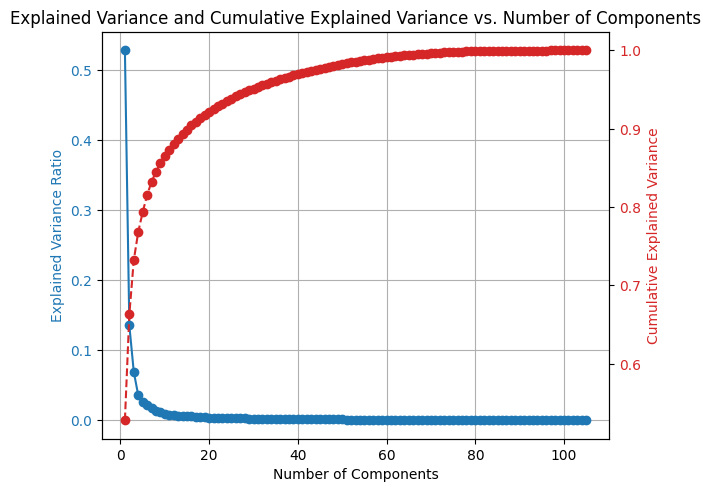

Enter the number of components based on the explained variance plot:  30


In [11]:
# Standardize the data
scaler = StandardScaler()
event_maps_scaled = scaler.fit_transform(event_maps_flattened)

# Apply PCA
pca = PCA()
pca.fit(event_maps_scaled)

# Explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio and cumulative explained variance
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance Ratio', color='tab:blue')
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', color='tab:blue', label='Explained Variance Ratio')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Explained Variance', color='tab:red')
ax2.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='tab:red', label='Cumulative Explained Variance')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Explained Variance and Cumulative Explained Variance vs. Number of Components')


plt.show()

# Choose the number of components based on the plot
n_components = int(input("Enter the number of components based on the explained variance plot: "))
pca = PCA(n_components=n_components)
event_maps_pca = pca.fit_transform(event_maps_scaled)

In [12]:
event_maps_pca.shape

(105, 30)

# K-Means

Number of clusters: 2, Silhouette Score: 0.4013793326696069
Number of clusters: 3, Silhouette Score: 0.4008174574994504
Number of clusters: 4, Silhouette Score: 0.364256881278238
Number of clusters: 5, Silhouette Score: 0.33375109402828634
Number of clusters: 6, Silhouette Score: 0.33617224250582967
Number of clusters: 7, Silhouette Score: 0.3341038679399484
Number of clusters: 8, Silhouette Score: 0.22562476750344518
Number of clusters: 9, Silhouette Score: 0.30847973467582285
Number of clusters: 10, Silhouette Score: 0.3462045045430644
Number of clusters: 11, Silhouette Score: 0.21570732408763818
Number of clusters: 12, Silhouette Score: 0.22907006584475767
Number of clusters: 13, Silhouette Score: 0.23152184403756026
Number of clusters: 14, Silhouette Score: 0.2346407110043855
Number of clusters: 15, Silhouette Score: 0.35052535557317976
Number of clusters: 16, Silhouette Score: 0.2310102066062489
Number of clusters: 17, Silhouette Score: 0.2397582282112293
Number of clusters: 18, S

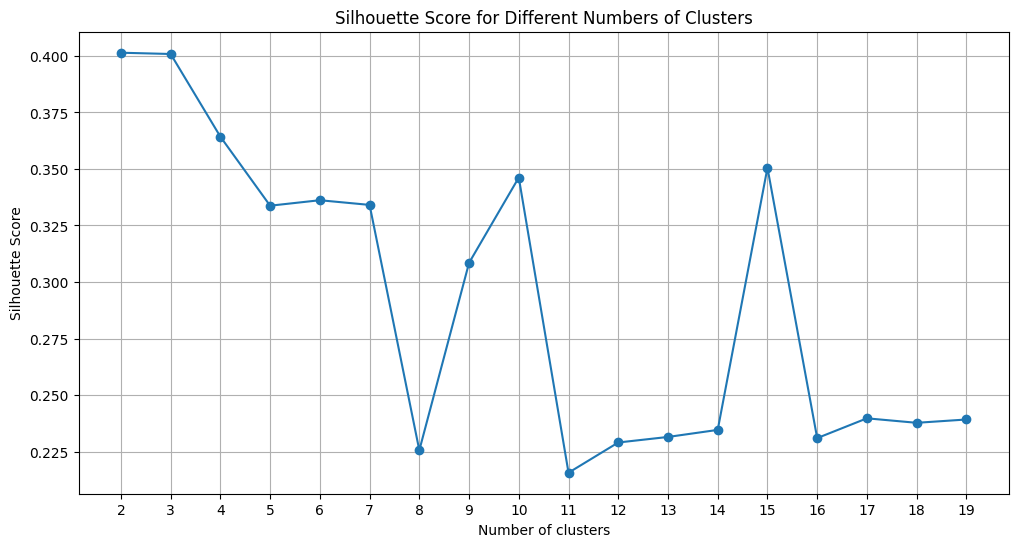

In [13]:
# Evaluate silhouette score for different number of clusters
K = range(2, 20)  # Start from 2 because silhouette score is not defined for a single cluster
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(event_maps_pca)
    score = silhouette_score(event_maps_pca, labels)
    silhouette_scores.append(score)
    print(f'Number of clusters: {k}, Silhouette Score: {score}')

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.xticks(np.arange(0, 20, step=1))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()


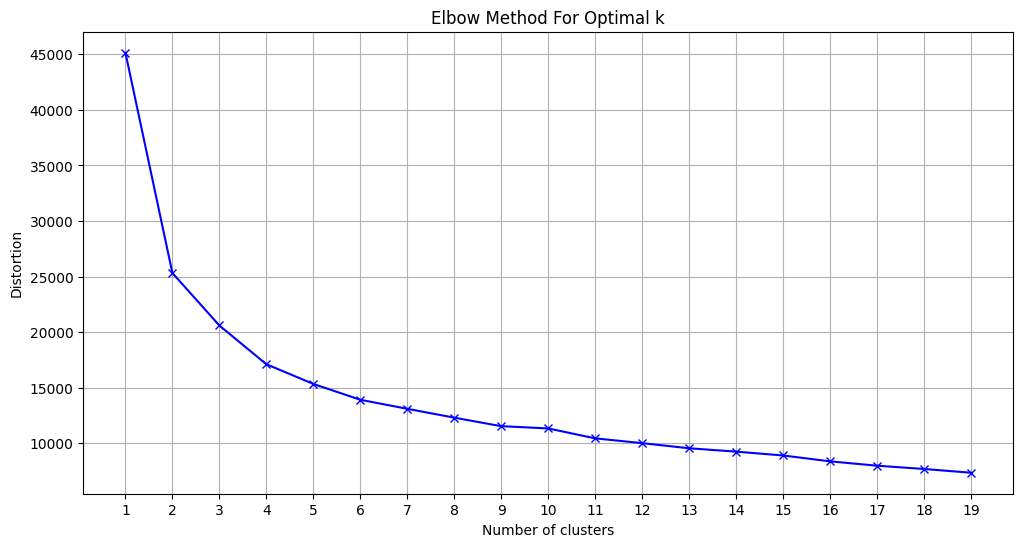

Enter the number of clusters based on the elbow method:  4


In [14]:
# Determine the optimal number of clusters using the elbow method
distortions = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(event_maps_pca)
    distortions.append(kmeans.inertia_)


plt.figure(figsize=(12, 6))
plt.xticks(np.arange(0, 20, step=1))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Apply KMeans clustering
optimal_k = int(input("Enter the number of clusters based on the elbow method: "))
kmeans = KMeans(n_clusters=optimal_k)
labels = kmeans.fit_predict(event_maps_pca)

# Agglomerative Clustering

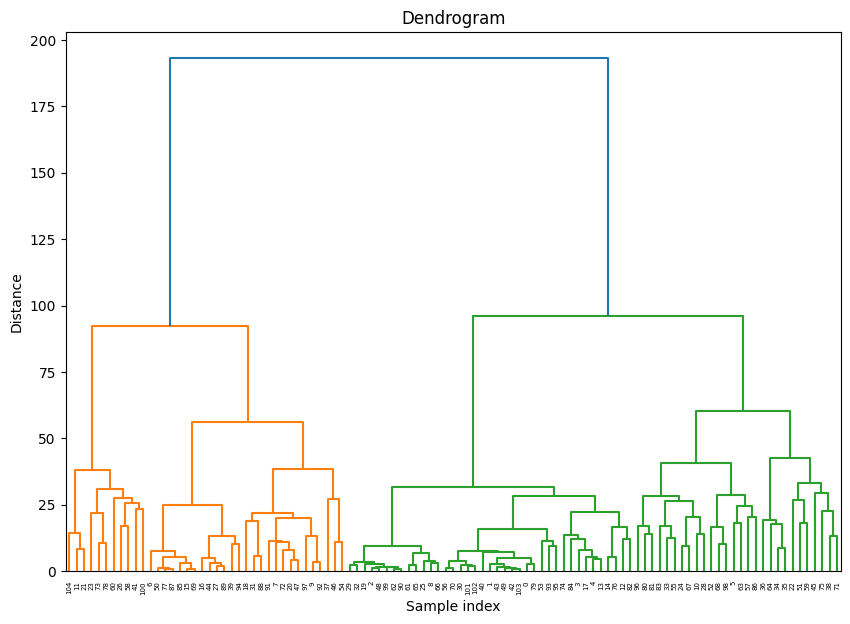

In [15]:
import scipy.cluster.hierarchy as sch

# Compute the linkage matrix
linkage_matrix = sch.linkage(event_maps_pca, method='ward')  # or 'complete', 'average', 'single'

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix)
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

N. of clusters: 2, Silhouette Score: 0.559104327793372
N. of clusters: 3, Silhouette Score: 0.5234984549098356
N. of clusters: 4, Silhouette Score: 0.5063348658473857
N. of clusters: 5, Silhouette Score: 0.49586183409909207
N. of clusters: 6, Silhouette Score: 0.4779853845194674
N. of clusters: 7, Silhouette Score: 0.47407428716613015
N. of clusters: 8, Silhouette Score: 0.4984638191238609
N. of clusters: 9, Silhouette Score: 0.5308856108402301
N. of clusters: 10, Silhouette Score: 0.5301407719046911
N. of clusters: 11, Silhouette Score: 0.5301936358758174
N. of clusters: 12, Silhouette Score: 0.5281619976870624
N. of clusters: 13, Silhouette Score: 0.5300167420838321
N. of clusters: 14, Silhouette Score: 0.5337559106346409
N. of clusters: 15, Silhouette Score: 0.5386232827334725
N. of clusters: 16, Silhouette Score: 0.5334813426640611
N. of clusters: 17, Silhouette Score: 0.529293480230885
N. of clusters: 18, Silhouette Score: 0.5192909999494711
N. of clusters: 19, Silhouette Score: 0

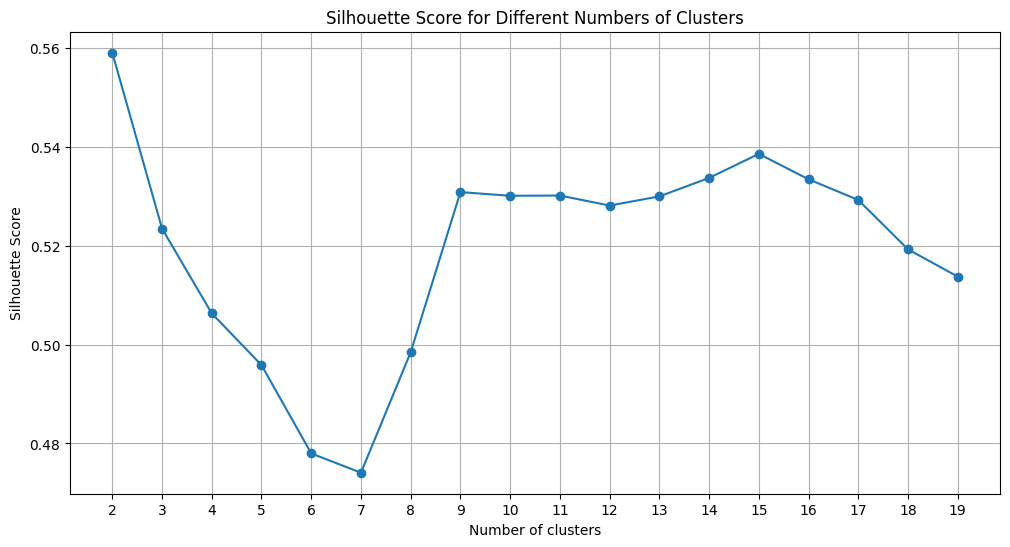

Enter the number of clusters based on the silhouette score analysis:  9


In [17]:
# Evaluate silhouette score for different number of clusters
K = range(2, 20)  # Start from 2 because silhouette score is not defined for a single cluster
silhouette_scores = []

for k in K:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average')
    labels = agglomerative_clustering.fit_predict(event_maps_pca)
    score = silhouette_score(event_maps_pca, labels, metric='cosine')
    silhouette_scores.append(score)
    print(f'N. of clusters: {k}, Silhouette Score: {score}')

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.xticks(np.arange(0, 20, step=1))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# Determine the optimal number of clusters
optimal_k = int(input("Enter the number of clusters based on the silhouette score analysis: "))
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_k, affinity='cosine', linkage='average')
labels = agglomerative_clustering.fit_predict(event_maps_pca)

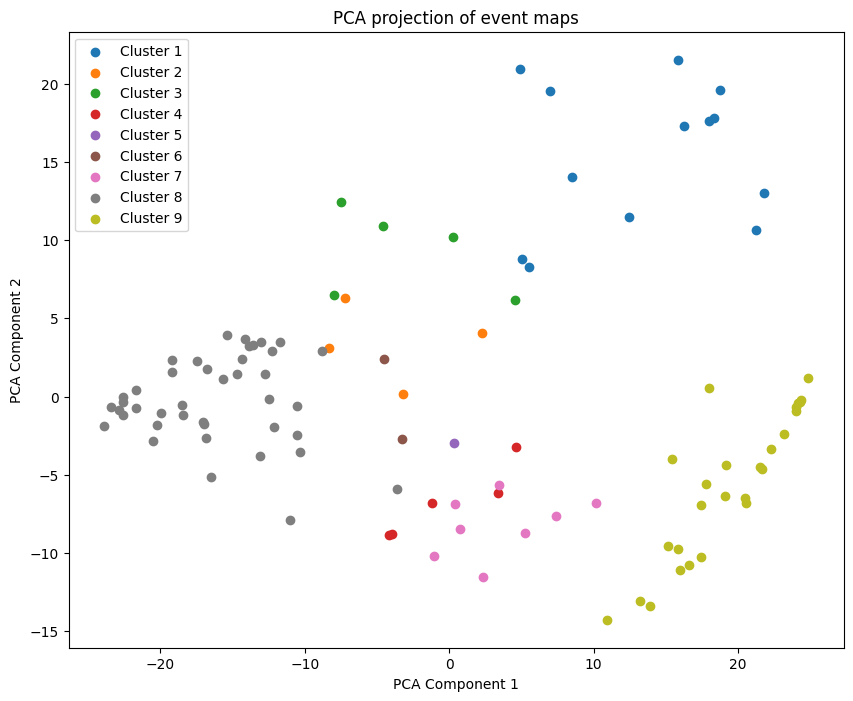

In [18]:
# Visualize clusters in PCA space
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    plt.scatter(event_maps_pca[labels == i, 0], event_maps_pca[labels == i, 1], label=f'Cluster {i + 1}')
plt.title('PCA projection of event maps')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [19]:
# Add cluster labels to the dataset
ds_heatwaves['cluster'] = (('time', 'lat', 'lon'), np.full(intensity.shape, np.nan))
for label, event_time in zip(labels, event_times):
    for t in event_time:
        ds_heatwaves['cluster'].loc[t] = label

In [20]:
labels

array([7, 7, 7, 7, 7, 3, 8, 8, 7, 8, 7, 0, 7, 7, 7, 8, 8, 7, 8, 7, 8, 0,
       2, 0, 6, 7, 0, 8, 7, 7, 7, 8, 7, 6, 2, 2, 2, 0, 1, 8, 7, 0, 7, 7,
       8, 0, 8, 8, 7, 7, 8, 5, 3, 7, 8, 6, 7, 1, 0, 5, 0, 7, 7, 3, 2, 7,
       7, 6, 3, 8, 7, 1, 8, 0, 7, 1, 7, 8, 0, 7, 6, 6, 7, 6, 7, 8, 4, 8,
       8, 8, 7, 8, 8, 7, 8, 7, 6, 8, 3, 7, 0, 7, 7, 7, 0], dtype=int64)

In [21]:
# Compute silhouette score
score = silhouette_score(event_maps_pca, labels, metric='cosine')
print(f'Silhouette Score: {score}')

Silhouette Score: 0.5308856108402301


In [22]:
print(f"PCA components shape: {pca.components_.shape}")
print(f"PCA transformed data shape: {event_maps_pca.shape}")
print(f"Labels shape: {labels.shape}")

PCA components shape: (30, 2236)
PCA transformed data shape: (105, 30)
Labels shape: (105,)


In [23]:
print(f"Flattened event maps shape: {event_maps_flattened.shape}")

Flattened event maps shape: (105, 2236)


In [24]:
# # Plot the dendrogram (optional, if required)
# import scipy.cluster.hierarchy as sch
# plt.figure(figsize=(10, 6))
# dendrogram = sch.dendrogram(sch.linkage(event_features_pca, method='ward'))
# plt.title('Dendrogram')
# plt.xlabel('Events')
# plt.ylabel('Euclidean Distances')
# plt.show()

In [25]:
# # Plot histogram of event durations for each cluster
# for cluster_label in np.unique(labels):
#     cluster_durations = [len(event_times[i]) for i in range(len(event_times)) if labels[i] == cluster_label]
#     plt.figure(figsize=(10, 6))
#     sns.histplot(cluster_durations, kde=False, bins=20)
#     plt.title(f'Duration Distribution for Cluster {cluster_label}')
#     plt.xlabel('Duration (days)')
#     plt.ylabel('Number of Events')
#     plt.show()

In [26]:
# # Plot histogram of spatial extent for each cluster
# for cluster_label in np.unique(labels):
#     cluster_extents = [np.mean(event_areas[i]) for i in range(len(event_areas)) if labels[i] == cluster_label]
#     plt.figure(figsize=(10, 6))
#     sns.histplot(cluster_extents, kde=False, bins=20)
#     plt.title(f'Spatial Extent Distribution for Cluster {cluster_label}')
#     plt.xlabel('Spatial Extent (%)')
#     plt.ylabel('Number of Events')
#     plt.show()

In [27]:
# Create a dictionary to store average maps for each cluster
cluster_maps = {}
cluster_sizes = {}

for cluster in range(optimal_k):
    # Get the indices of events in this cluster
    cluster_event_indices = np.where(labels == cluster)[0]
    
    # Calculate the number of events in this cluster
    cluster_sizes[cluster] = len(cluster_event_indices)
    
    # Select and compute the mean map for this cluster
    cluster_events = event_maps_da.isel(event=cluster_event_indices)
    cluster_mean_map = cluster_events.mean(dim='event')
    cluster_maps[f'Cluster {cluster}'] = cluster_mean_map

# Create plots for each cluster with updated titles
plots = []
for cluster, cluster_mean_map in cluster_maps.items():
    # Extract cluster number from the string
    cluster_number = int(cluster.split(' ')[-1])
    
    plot = cluster_mean_map.hvplot.image(
        x='lon', y='lat', geo=True, cmap='fire_r', clim= (0.5,4), xlabel='Longitude', ylabel='Latitude', clabel='Intensity [°C]',
        title=f'{cluster} Mean Intensity Map\nNumber of Events: {cluster_sizes[cluster_number]}', 
        tiles='CartoLight', width=500, height=700
    )
    plots.append(plot)

# Create the layout with two columns
n_plots = len(plots)
n_cols = 2  # Number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Compute number of rows needed

# Create a list of rows with plots
rows = []
for i in range(n_rows):
    start_idx = i * n_cols
    end_idx = start_idx + n_cols
    row_plots = plots[start_idx:end_idx]
    row = pn.Row(*row_plots)
    rows.append(row)

# Combine all rows into a single layout
combined_plot = pn.Column(*rows)
combined_plot.servable()

Column
    [0] Row
        [0] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
        [1] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
    [1] Row
        [0] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
        [1] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
    [2] Row
        [0] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
        [1] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
    [3] Row
        [0] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
        [1] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)
    [4] Row
        [0] HoloViews(Overlay, height=700, sizing_mode='fixed', width=500)

In [28]:
# Save clusters plots
cluster_maps = {}
cluster_sizes = {}

for cluster in range(optimal_k):
    # Get the indices of events in this cluster
    cluster_event_indices = np.where(labels == cluster)[0]
    
    # Calculate the number of events in this cluster
    cluster_sizes[cluster] = len(cluster_event_indices)
    
    # Select and compute the mean map for this cluster
    cluster_events = event_maps_da.isel(event=cluster_event_indices)
    cluster_mean_map = cluster_events.mean(dim='event')
    cluster_maps[f'Cluster {cluster}'] = cluster_mean_map

# Create plots for each cluster with updated titles
plots = []
for cluster, cluster_mean_map in cluster_maps.items():
    # Extract cluster number from the string
    cluster_number = int(cluster.split(' ')[-1])
    
    plot = cluster_mean_map.hvplot.image(
        x='lon', y='lat', geo=True, cmap='fire_r', clim=(0.5, 4),
        xlabel='Longitude', ylabel='Latitude', clabel='Intensity [°C]',
        title=f'{cluster} Mean Intensity Map\nNumber of Events: {cluster_sizes[cluster_number]}',
        tiles='CartoLight', width=500, height=700
    )
    plots.append(plot)

# Combine all plots into a grid layout
combined_plot = hv.Layout(plots).cols(3)  # 2 columns, automatically calculates rows

# Set some options (optional)
combined_plot.opts(opts.Image(width=500, height=700))

# Save the combined plot as a PNG image
hv.save(combined_plot, 'cluster_max_maps.png', fmt='png')
combined_plot

:Layout
   .Overlay.I    :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.II   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.III  :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.IV   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.V    :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.VI   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.VII  :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.VIII :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)
   .Overlay.IX   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (event_map)

In [29]:
import panel as pn
# Initialize Panel extension
pn.extension()

# Create a dictionary to store average maps for each cluster
cluster_maps = {}
cluster_sizes = {}
for cluster in range(optimal_k):
    cluster_event_indices = np.where(labels == cluster)[0]
    cluster_sizes[cluster] = len(cluster_event_indices)
    cluster_events = event_maps_da.isel(event=cluster_event_indices)
    cluster_mean_map = cluster_events.mean(dim='event')
    cluster_maps[f'Cluster {cluster}'] = cluster_mean_map

# Create a dictionary for event maps for each cluster
event_maps_dict = {cluster: event_maps_da.isel(event=np.where(labels == int(cluster.split(' ')[-1]))[0])
                   for cluster in cluster_maps.keys()}

def update_cluster_plot(cluster_number):
    cluster_mean_map = cluster_maps[f'Cluster {cluster_number}']
    return cluster_mean_map.hvplot.image(
        x='lon', y='lat', geo=True, cmap='fire_r', clim= (0.5,3.5),
        xlabel='Longitude', ylabel='Latitude', clabel='Intensity [°C]',
        title=f'Cluster {cluster_number} Mean Intensity Map\nNumber of Events: {cluster_sizes[cluster_number]}',
        tiles='CartoLight', width=500, height=700
    )

def update_event_map(event_index, cluster_number):
    event_map = event_maps_dict[f'Cluster {cluster_number}'][event_index]
    return event_map.hvplot.image(
        x='lon', y='lat', geo=True, cmap='fire_r', clim= (0.5,3.5),
        xlabel='Longitude', ylabel='Latitude', clabel='Intensity [°C]',
        title=f'Event Map {event_index} in Cluster {cluster_number}',
        tiles='CartoLight', width=500, height=700
    )

# Create interactive widgets
cluster_selector = pn.widgets.IntSlider(name='Select Cluster', start=0, end=optimal_k-1, step=1, value=0)

# Initialize event_selector with a dummy range
event_selector = pn.widgets.IntSlider(name='Select Event', start=0, end=len(event_maps_dict['Cluster 0'])-1, step=1, value=0)

# Define function to update event_selector range based on selected cluster
def update_event_selector_range(cluster_number):
    num_events = len(event_maps_dict[f'Cluster {cluster_number}'])
    event_selector.end = num_events - 1
    event_selector.value = min(event_selector.value, num_events - 1)
    return event_selector

# Create dynamic maps
cluster_plot = pn.bind(update_cluster_plot, cluster_number=cluster_selector)
event_map_plot = pn.bind(update_event_map, event_index=event_selector, cluster_number=cluster_selector)

# Update event_selector range when cluster_selector changes
cluster_selector.param.watch(lambda event: update_event_selector_range(event.new), 'value')

# Layout with two plots
layout = pn.Row(
    pn.Column(cluster_selector, cluster_plot),
    pn.Column(event_selector, event_map_plot)
)

# Serve the layout
layout.servable()


Row
    [0] Column
        [0] IntSlider(end=8, name='Select Cluster')
        [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] Column
        [0] IntSlider(end=12, name='Select Event')
        [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [30]:
da_intensity = ds_heatwaves['intensity']
da_clusters = ds_heatwaves['cluster']
mask_cluster = ~np.isnan(da_intensity.compute())
# Ensure mask is of the same shape as da_intensity
mask_cluster_xr = xr.DataArray(mask_cluster, coords=da_intensity.coords, dims=da_intensity.dims)
da_clusters_masked = da_clusters.where(mask_cluster_xr, drop=1)

In [31]:
plot = da_clusters_masked.hvplot(
            groupby= 'time',
            geo=True,
            cmap='Set1', clim=(-0.5,optimal_k),
            xlabel='Longitude', ylabel='Latitude',
            clabel='Intensity [°C]',
            tiles='CartoLight',
            width=700,
            height=500
        )
plot

:DynamicMap   [time]
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (cluster)